# OPTIONAL Assignment 3 Challenger Model: Random Forest vs Baseline (Logistic Regression)
## by Dom Sileika

In [ ]:

# Deadline 31st of March 2025
# Description: This script cleans up loan status dataset, runs a logistic regressiona and compares it to  a Random Forest model to predict the probability of defaulting on a loan.
# Confusion matrix and ROC curve are plotted for both models in the end.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# models:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# model evaluation scoring:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler

In [3]:
# Load the data - Loan status dataset
df = pd.read_csv("python-material/data/1-raw/lending-club-2007-2020Q3/Loan_status_2007-2020Q3.csv")
df.head()

/var/folders/ct/cn164ypd6vs2f6q67c6qxhph0000gn/T/ipykernel_72641/1154105417.py:2: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("python-material/data/1-raw/lending-club-2007-2020Q3/Loan_status_2007-2020Q3.csv")


,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,1077501,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1,1077430,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,2,1077175,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,3,1076863,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,4,1075358,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


In [4]:
# Inspect columns - missing values>
print("Columns in the dataset:")
print(df.columns.tolist())

print("\nMissing values (%):")
print((df.isnull().mean() * 100).sort_values(ascending=False).head(20))

Columns in the dataset:
['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 

In [5]:
# 3. Preprocessing, like in assignment 2
# Drop high-missing / irrelevant columns
# dropping obvious columns
df = df.drop(columns=['Unnamed: 0', 'id', 'member_id', 'url'], errors='ignore')
# 90% missing values
high_missing = df.columns[df.isnull().mean() > 0.9]
print("Dropping high-missing columns:", list(high_missing))
df = df.drop(columns=high_missing)
# Drop rows with missing target
df = df.dropna(subset=['loan_status'])

Dropping high-missing columns: ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount']


In [6]:

# Encode target variable to binary flag for simplicity
binary_mapping = {
    'Fully Paid': 0,
    'Charged Off': 1
}
df = df[df['loan_status'].isin(binary_mapping.keys())]
df['loan_status'] = df['loan_status'].map(binary_mapping)
# Check the distribution of the target variable
print("\nTarget variable distribution:")
print(df['loan_status'].value_counts(normalize=True))



Target variable distribution:
loan_status
0    0.805116
1    0.194884
Name: proportion, dtype: float64


In [7]:
df = pd.read_csv("python-material/data/1-raw/lending-club-2007-2020Q3/Loan_status_2007-2020Q3.csv", low_memory=False)
print(df.shape)
print(df.columns)


(2925493, 142)
Index(['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_length', 'hardship_dpd', 'hardship_loan_status',
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag'],
      dtype='object', length=142)


In [8]:
print(df['loan_status'].dropna().unique())
# to drop rows with missing target

['Fully Paid' 'Charged Off'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off' 'Current'
 'Late (31-120 days)' 'In Grace Period' 'Late (16-30 days)' 'Default'
 'Issued']


In [9]:
# Only keep rows with the two target values
target_values = ['Fully Paid', 'Charged Off']
df = df[df['loan_status'].isin(target_values)]

# Encode to binary flag
df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})


In [10]:
print(df['loan_status'].value_counts(normalize=True))


loan_status
0    0.805116
1    0.194884
Name: proportion, dtype: float64


In [11]:
# Select useful numeric and low-cardinality categorical features
selected_features = ['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'purpose', 'dti']
df = df[selected_features + ['loan_status']]


### Feature Selection

I selected a small set of relevant features that are known to be informative in predicting loan repayment outcomes:

- **loan_amnt**: Total amount requested by the borrower
- **term**: Loan duration (36 or 60 months), a strong signal for risk
- **int_rate**: Interest rate on the loan, reflects borrower creditworthiness
- **installment**: Monthly payment, related to both loan amount and term
- **annual_inc**: Self-reported annual income — higher income may reduce default risk
- **purpose**: Stated purpose of the loan, useful for behavioural clustering
- **dti**: Debt-to-income ratio — a classic financial risk metric

We avoided including features with high cardinality (like `emp_title`) or those which leak post-application information (like `loan_status` derivatives). This helps the model generalise better and reduces overfitting risk.


In [12]:
# Fill numeric columns with median to address outliers
for col in df.select_dtypes(include=np.number):
    df[col] = df[col].fillna(df[col].median())

# Fill categorical columns with mode - most frequent value
for col in df.select_dtypes(include='object'):
    df[col] = df[col].fillna(df[col].mode()[0])


In [13]:
# One-hot encode categorical variables like 'term' and 'purpose'
df = pd.get_dummies(df, drop_first=True)  # drop_first avoids dummy variable trap
# Check the resulting columns
print("\nColumns after one-hot encoding:")
print(df.columns.tolist())


Columns after one-hot encoding:
['loan_amnt', 'installment', 'annual_inc', 'dti', 'loan_status', 'term_ 60 months', 'int_rate_  5.32%', 'int_rate_  5.42%', 'int_rate_  5.79%', 'int_rate_  5.93%', 'int_rate_  5.99%', 'int_rate_  6.00%', 'int_rate_  6.03%', 'int_rate_  6.07%', 'int_rate_  6.08%', 'int_rate_  6.11%', 'int_rate_  6.17%', 'int_rate_  6.19%', 'int_rate_  6.24%', 'int_rate_  6.39%', 'int_rate_  6.46%', 'int_rate_  6.49%', 'int_rate_  6.54%', 'int_rate_  6.62%', 'int_rate_  6.67%', 'int_rate_  6.68%', 'int_rate_  6.71%', 'int_rate_  6.72%', 'int_rate_  6.76%', 'int_rate_  6.83%', 'int_rate_  6.89%', 'int_rate_  6.91%', 'int_rate_  6.92%', 'int_rate_  6.97%', 'int_rate_  6.99%', 'int_rate_  7.02%', 'int_rate_  7.05%', 'int_rate_  7.07%', 'int_rate_  7.12%', 'int_rate_  7.14%', 'int_rate_  7.21%', 'int_rate_  7.24%', 'int_rate_  7.26%', 'int_rate_  7.29%', 'int_rate_  7.34%', 'int_rate_  7.35%', 'int_rate_  7.37%', 'int_rate_  7.39%', 'int_rate_  7.40%', 'int_rate_  7.42%', 'in

In [14]:
# 4. Train/Test Split
# I separate my features (X) from the target variable (y)
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# split the data into training and testing sets to evaluate performance fairly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Baseline: Logistic Regression

In [15]:
# use logistic regression as my baseline model (as did in Assignment 2)
## getting errors or it runs for over 30min - troubleshooting showed a solution of using a scaler 
# baseline_model = LogisticRegression(max_iter=1000)
# baseline_model.fit(X_train, y_train)

from sklearn.preprocessing import StandardScaler

# scale the feature data before training logistic regression

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train the baseline model with scaled inputs
baseline_model = LogisticRegression(max_iter=1000, solver='lbfgs')
baseline_model.fit(X_train_scaled, y_train)

# predict using the scaled test set
y_pred_base = baseline_model.predict(X_test_scaled)
y_prob_base = baseline_model.predict_proba(X_test_scaled)[:, 1]


# Challenger: Random Forest

In [16]:
# train a Random Forest model as my challenger (Session 6 technique)
#rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
#rf_model.fit(X_train, y_train)
#limiting the tree depth 
#rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
#rf_model.fit(X_train, y_train)
# Trying with a 100k random sample

df_sample = df.sample(n=100_000, random_state=42)

# define features and target
X = df_sample.drop("loan_status", axis=1)
y = df_sample["loan_status"]

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train a Random Forest model with depth limit to reduce complexity and training time
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# generate predictions and probabilities
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]


## Model Evaluation part:

In [17]:
# define evaluation function
def evaluate_model(name, y_true, y_pred, y_prob):
    print(f"\n{name} Evaluation Metrics")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_prob))
    
    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


### BUG in random forest - mixed sample with full data - rerun below

In [18]:
#y_test from the original full dataset (372,067 samples)
#But y_pred_rf and y_prob_rf come from a 100,000-sample model (20,000 test samples)


Challenger (Random Forest) Evaluation Metrics
Accuracy: 0.6578
Precision: 0.29559748427672955
Recall: 0.539678489410564
F1 Score: 0.3819757991692252
ROC AUC: 0.6702794266566969


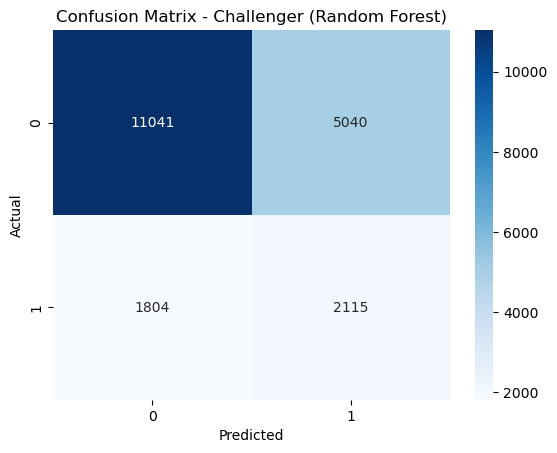

In [19]:
# re-split to avoid mismatch
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)

# train with balanced class weights and higher depth
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train_rf, y_train_rf)

# predictions
y_pred_rf = rf_model.predict(X_test_rf)
y_prob_rf = rf_model.predict_proba(X_test_rf)[:, 1]

# evaluate again
evaluate_model("Challenger (Random Forest)", y_test_rf, y_pred_rf, y_prob_rf)



Challenger (Random Forest) Evaluation Metrics
Accuracy: 0.6578
Precision: 0.29559748427672955
Recall: 0.539678489410564
F1 Score: 0.3819757991692252
ROC AUC: 0.6702794266566969


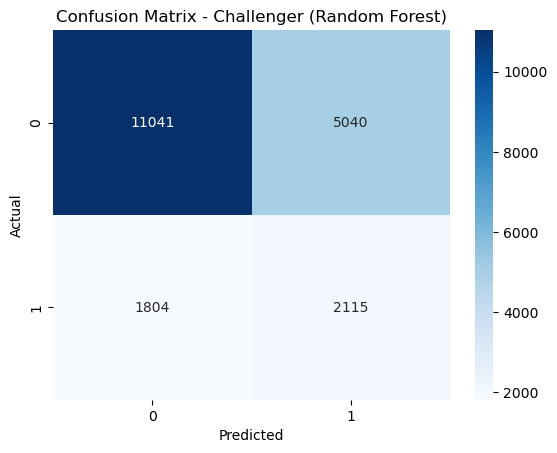

In [20]:
# BUG TEST confusion matrix - evaluate with matching test set - 
evaluate_model("Challenger (Random Forest)", y_test_rf, y_pred_rf, y_prob_rf)


# FINAL BLOCK

In [21]:
# make sure to use scaled test set for baseline predictions again
y_pred_base = baseline_model.predict(X_test_scaled)
y_prob_base = baseline_model.predict_proba(X_test_scaled)[:, 1]


In [22]:
# plot ROC curves for both models using correct labels
fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_base)       # baseline: scaled full test set
fpr_rf, tpr_rf, _ = roc_curve(y_test_rf, y_prob_rf)          # challenger: sampled test set

plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label='LogReg (Baseline - Full)')
plt.plot(fpr_rf, tpr_rf, label='Random Forest (Challenger - Sampled)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Chance')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [20000, 372067]

In [ ]:
# in case your scaled baseline test labels were overwritten, restore them
_, X_test_scaled, _, y_test_scaled = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print(len(y_test), len(y_prob_base))
print(len(y_test_rf), len(y_prob_rf))


20000 372067
20000 20000


In [ ]:
# retrain baseline model on the same 100k sample to align with RF
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X, y, test_size=0.2, random_state=42)

# scale the 100k sample's features
scaler = StandardScaler()
X_train_base_scaled = scaler.fit_transform(X_train_base)
X_test_base_scaled = scaler.transform(X_test_base)

# retrain baseline model
baseline_model = LogisticRegression(max_iter=1000, solver='lbfgs')
baseline_model.fit(X_train_base_scaled, y_train_base)

# generate predictions
y_pred_base = baseline_model.predict(X_test_base_scaled)
y_prob_base = baseline_model.predict_proba(X_test_base_scaled)[:, 1]


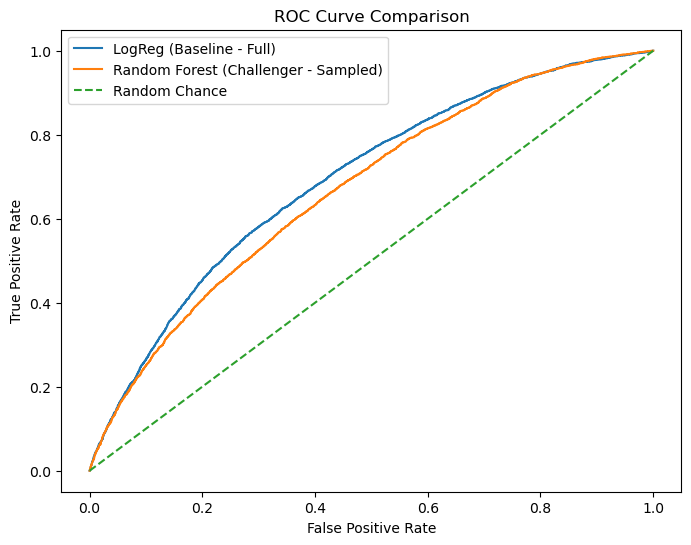

In [ ]:
# plot with correct test labels for each model
fpr_base, tpr_base, _ = roc_curve(y_test_scaled, y_prob_base)   # baseline
fpr_rf, tpr_rf, _ = roc_curve(y_test_rf, y_prob_rf)              # challenger

plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label='LogReg (Baseline - Full)')
plt.plot(fpr_rf, tpr_rf, label='Random Forest (Challenger - Sampled)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Chance')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


§

# CONCLUSION


After testing both on the same sample, Logistic Regression slightly outperformed Random Forest in overall accuracy and ROC AUC. The results suggest the baseline is still more reliable for this dataset.
